# Bone Age Regression
+ The objective of this competition is to create a model that predict the Bone Age of children from a Hand X-Ray.
+ The training data comes from the RSNA 2017 comp. ,but the test dataset is from a real brazilian hospital provided by [DATA H](http://www.datah.ai/)
+ The training dataset contains only images with the left hand (RSNA 2017 competition) but the test dataset contains some images with both hands from a hospital in Brazil. It means that, even though the model will be trained in a different distribution and only with images containing a single hand, it should work with images containing both hands.
+ Both datasets (training and test) have a tabular variable which is gender
 
The aproach for this problem was:
1. Split the test images that constain two hands and save both in order to make a mean aggreation to obtain the real age of the bone. We observed that there were images with hands fliped vertically.
2. To make the model able to predict the bone age in situations like (left hand, right hand, vertically flipped hand), I decidede to insert image augmentations for the train but also for the test in order to create a model indistinguishable to these changes.

# Resnet Model with Gender

## 1. Importing Libraries

In [1]:
! pip install -q albumentations
! pip install -q pretrainedmodels
! pip install iterative-stratification
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import cv2
import time
import glob
import matplotlib.pyplot as plt
import albumentations as A
import pretrainedmodels
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import warnings
import gc
from tqdm import tqdm
from albumentations import pytorch as AT
from sklearn.metrics import mean_squared_error
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.optim import lr_scheduler
from sklearn.model_selection import StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_absolute_error
# Give ggplot style to images
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 2. Functions

In [2]:
def seed_everything(seed=1234):
    '''
    Function to put a seed to every step and make code reproducible
    Input:
    - seed: random state for the events 
    '''
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def imshow_gray(inp, title=None):
    '''
    Funtion to plot a tensor in gray scale
    '''
    
    plt.imshow(inp,cmap='gray', vmin=0, vmax=255)
    plt.pause(0.001)  # pause a bit so that plots are updated

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
    
def apply_filename_name(row):
    return row['fileName'].split('/')[4].split('_side_')[1]

def apply_filename_side(row):
    return row['ImageFile'].split('/')[4].split('_side_')[0]

def apply_filename_name2(row):
    return row['ImageFile'].split('/')[4].split('_side_')[1]


seed = 64
seed_everything(seed = seed)  

## 3. Exploring Data

In [3]:
# Path in which all the files are saved
path           = '/kaggle/input/i2a2-bone-age-regression'
path_train_csv = os.path.join(path, 'train.csv')
path_test_csv  = os.path.join(path, 'test.csv')
path_images    = os.path.join(path, 'images')


In [4]:
# Reading Train & Test csv (Test csv has the indicator of how many hands are int the image
# and the vertical line that separate them)
df_train = pd.read_csv(path_train_csv)
df_test = pd.read_csv(path_test_csv)
df_train.head(5)

,fileName,patientSex,boneage
0,1377.png,F,180
1,1378.png,F,12
2,1379.png,F,94
3,1380.png,M,120
4,1381.png,F,82


We will check how are the distributions in train & test images

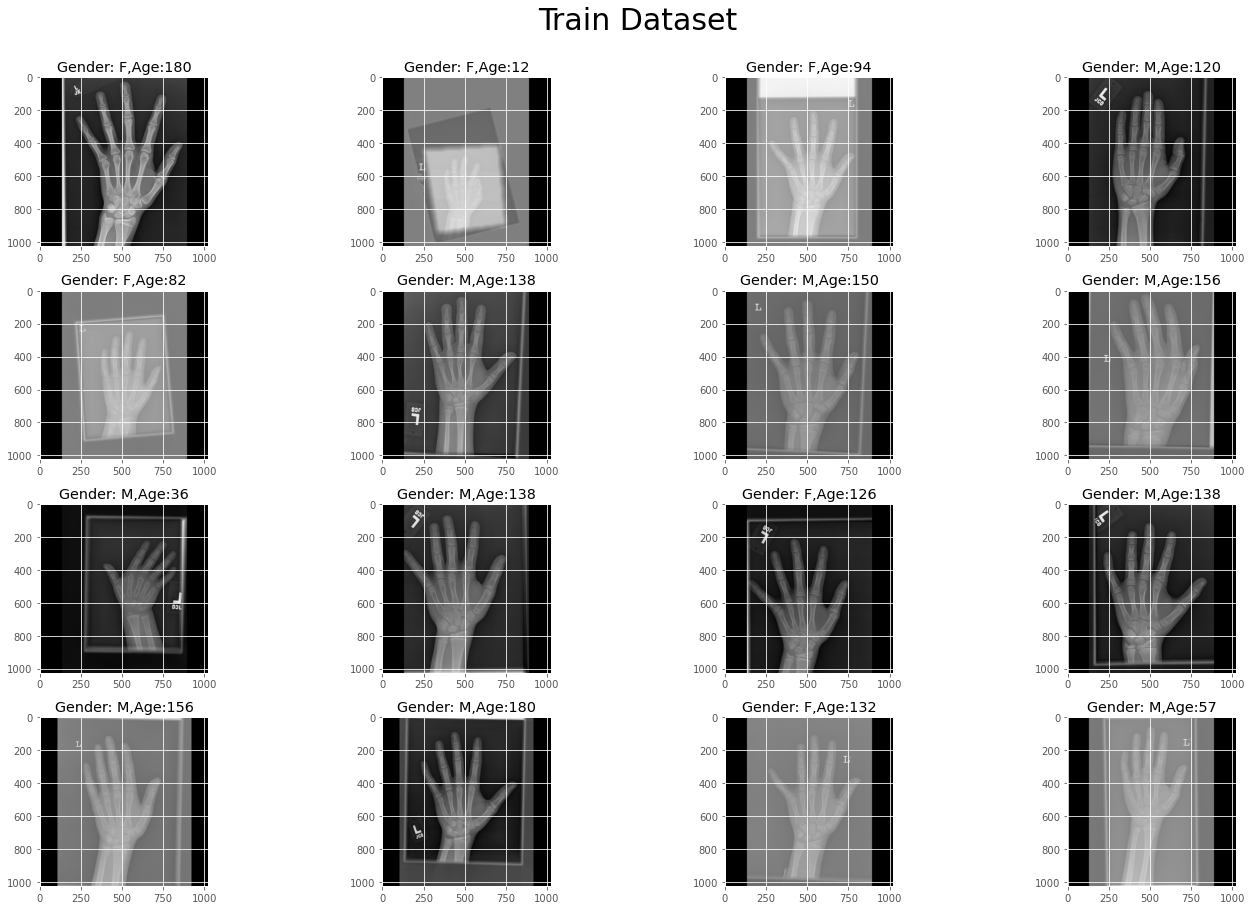

In [5]:
# Visualizing some images from train
row = 4; col = 4;
plt.figure(figsize=(20,(row/col)*12))
plt.suptitle("Train Dataset",  y=1.05, fontsize=30)
for j in range(row*col):
    plt.subplot(row,col,j+1)
    plt.imshow(cv2.imread(os.path.join(path_images,df_train.fileName.values[j])))
    plt.title('Gender: ' + str(df_train.patientSex.values[j]) + ',Age:' + str(df_train.boneage.values[j]))
plt.tight_layout()
plt.show()

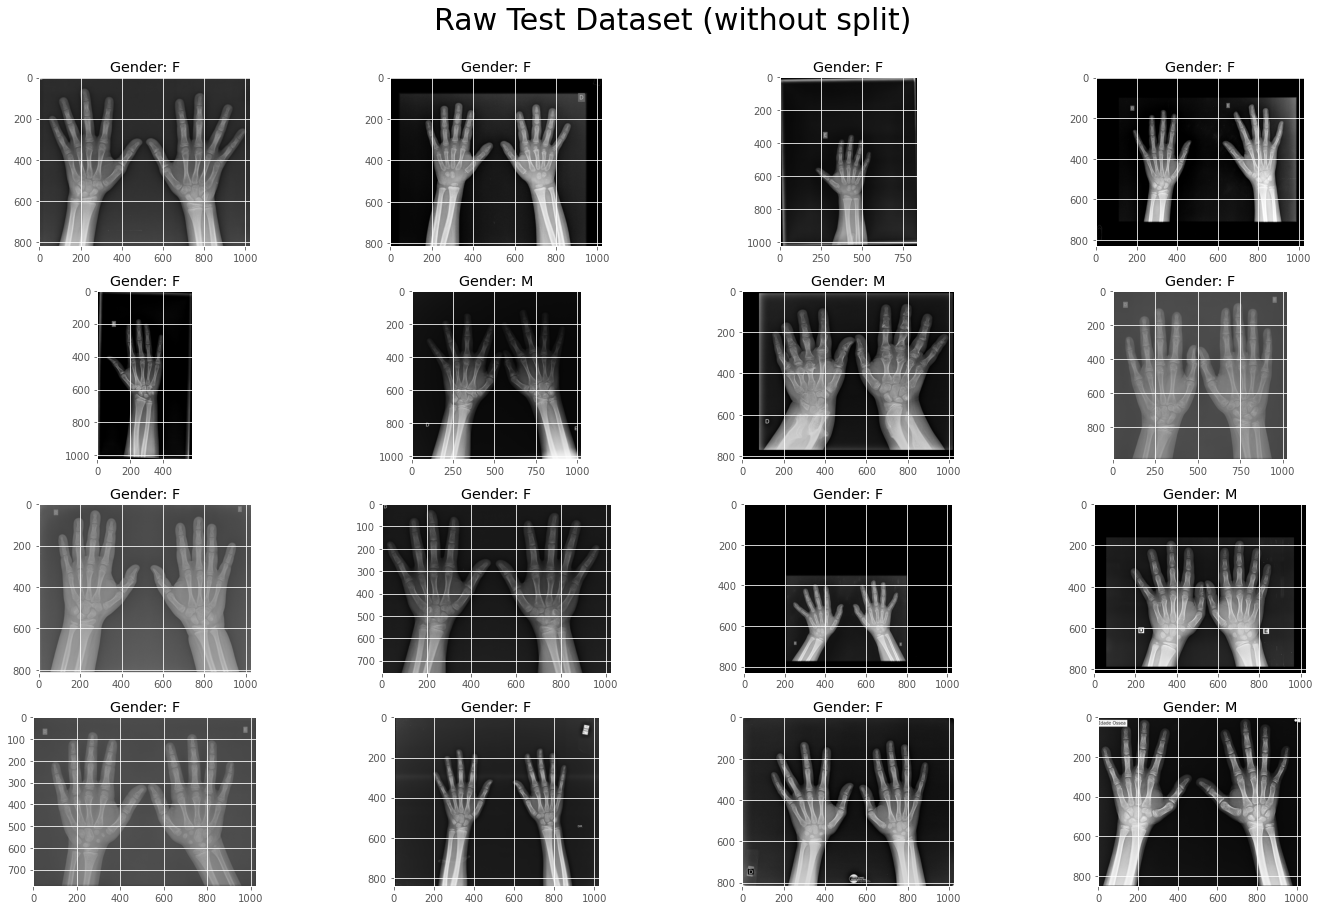

In [6]:
# Visualizing some images from test
row = 4; col = 4;
plt.figure(figsize=(20,(row/col)*12))
plt.suptitle("Raw Test Dataset (without split)",  y=1.05, fontsize=30)
for j in range(row*col):
    plt.subplot(row,col,j+1)
    plt.imshow(cv2.imread(os.path.join(path_images,df_test.fileName.values[j])))
    plt.title('Gender: ' + str(df_test.patientSex.values[j]))
plt.tight_layout()
plt.show()

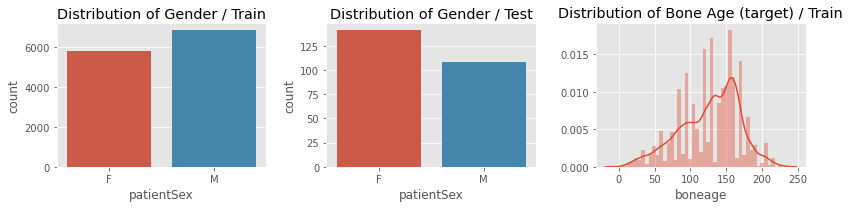

In [7]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
sns.countplot(x="patientSex", data=df_train)
plt.title('Distribution of Gender / Train')
plt.subplot(1,3,2)
sns.countplot(x="patientSex", data=df_test)
plt.title('Distribution of Gender / Test')
plt.subplot(1,3,3)
sns.distplot(df_train['boneage'])
plt.title('Distribution of Bone Age (target) / Train')
plt.tight_layout()
plt.show()

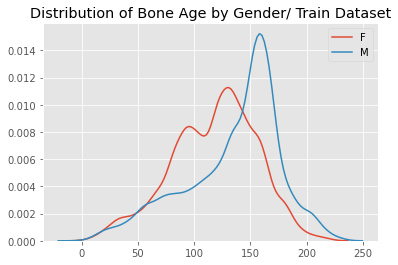

In [8]:
unique_vals = df_train['patientSex'].unique() 
targets = [df_train.loc[df_train['patientSex'] == val] for val in unique_vals]
for target in targets:
    plt.title('Distribution of Bone Age by Gender/ Train Dataset')
    sns.distplot(target[['boneage']], hist=False, rug=False, label = target['patientSex'].unique()[0])


we can see that the distribution of the bone age is different for each gender, so we decided to include the gender in our neural network in order to improve our prediction

# 4. Validation Strategy

+ We make a multi label stratified split because the distributions of the bone age are different for each gender. In order to make a stratified in a regression, we have to discretize the target in chunks and then make a split.

+ We are using the library MultilabelStratifiedKFold, but we select just 1 fold for validation and 4 folds for training as in a simple train-test split (80-20%)

## 4.1 Generate the folds 

In [9]:
# Number of folds in order to make a 80-20% training
n_folds= 5
# Dataframe that will store the folds
df_fold = pd.read_csv(path_train_csv)
# Discretize the bone age
df_fold['qcut'] =pd.qcut(df_train['boneage'], 10 , labels=False)
# Initializing the multilabel stratification
mskf = MultilabelStratifiedKFold(n_splits = n_folds, shuffle = False, random_state = None)
for fold,(train_index, test_index) in enumerate(mskf.split(df_fold, df_fold[['patientSex','qcut']])):
    df_fold.loc[test_index,'fold'] = fold

# Save the CSV with folds for training
df_fold.to_csv('folds.csv')
df_fold.head(5)

,fileName,patientSex,boneage,qcut,fold
0,1377.png,F,180,9,4.0
1,1378.png,F,12,0,4.0
2,1379.png,F,94,1,2.0
3,1380.png,M,120,3,3.0
4,1381.png,F,82,1,0.0


## 4.2 Verification of the distributions

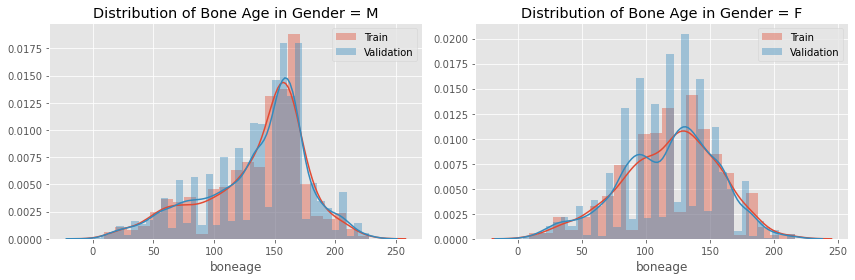

In [10]:
# Selecting the data for training and validation
df_ttrain = df_fold[df_fold['fold'] == 0].reset_index(drop=True)
df_tval = df_fold[df_fold['fold'] != 0].reset_index(drop=True)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(df_ttrain[df_ttrain['patientSex']=='M']['boneage'], label = 'Train')
sns.distplot(df_tval[df_tval['patientSex']=='M']['boneage'],label = 'Validation')
plt.legend()
plt.title('Distribution of Bone Age in Gender = M')
plt.subplot(1,2,2)
sns.distplot(df_ttrain[df_ttrain['patientSex']=='F']['boneage'], label = 'Train')
sns.distplot(df_tval[df_tval['patientSex']=='F']['boneage'],label = 'Validation')
plt.legend()
plt.title('Distribution of Bone Age in Gender = F')
plt.tight_layout()
plt.show()

We can see now that our train and validation has the same distribution on each gender and this will permit to create a fair model for each gender

# 5. Functions and Classes for Modeling

## 5.1 Utils 

+ This part was created based on the code of Abishek Thakur and his library [WFTML (Well That's Fantastic Machine Learning)](https://github.com/abhishekkrthakur/wtfml)

In [11]:
class EarlyStopping:
    '''
    Class for using early stoping with Pytorch
    '''
    def __init__(self, patience=7, mode="max", delta=0.0001,last_val_score = None):
        '''
        Init Function:
        - patience       : Patience for doing early stopping
        - mode           : 'max' if we want to optimize a metric in which more is better, else 'min'.
        - delta          : Use to check if the score improve or not in a significant way
        - last_val_score : Last value of the metric for checking early stopping 
                           if we want to continue training a model
        '''
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if last_val_score:    
            if self.mode == "min":
                self.val_score = -last_val_score
                self.best_score = -last_val_score
            else:
                self.val_score = last_val_score
                self.best_score = last_val_score
        else:
            if self.mode == "min":
                self.val_score = np.Inf
            else:
                self.val_score = -np.Inf

    def __call__(self, epoch , epoch_score,model,optimizer,model_path,all_path):
        '''
        Call for check if the counter of early stopping increase
        '''
        
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch , epoch_score,model,optimizer,model_path,all_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch ,epoch_score,model,optimizer,model_path,all_path)
            self.counter = 0

    def save_checkpoint(self, epoch , epoch_score,model,optimizer,model_path,all_path):
        '''
        Function  to save the best model if its better on each iteration
        Input:
        - epoch       : Epoch in which is the model
        - epoch_score : Score (Metric specified) on the actual epoch
        - model       : Actual model that is been training
        - optimizer   : Actual optimizer that is been training
        - model_path  : Path in which only the model will be saved
        - all_path    : Path in which the model, optimizer and more parameters will be saved
        '''
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            # Save parameters of the model
            torch.save(model.state_dict(), model_path)
            # Save Model, optimizer and more parameters
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_score': epoch_score,
                }, all_path)
        self.val_score = epoch_score
        
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):

        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


## 5.2 Dataset Class

+ In this case we are adding the tabular variable gender inside the network arquitechture, so to make things easier, we will pass the gender in our data loader

In [12]:
class BoneAgeDataset_withGender():
    '''
    Class for loading the images and gender of Bone Age Regression Dataset
    '''
    def __init__(self, image_paths,gender,targets, augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations
        self.gender = gender

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        #Calculate image and targets
        image   = cv2.imread(self.image_paths[item])
        targets = self.targets[item]
        gender  = self.gender[item]
        # Because is a gray image is not necessary to convert BGR to RGB 
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Augmentations
        if self.augmentations is not None: 
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        
        # Return the image in Tensor format (First the Channels) 
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)   
        
        return {
            "image": torch.tensor(image, dtype=torch.float), 
            "targets": torch.tensor(targets, dtype=torch.long),
            "gender": torch.tensor(gender, dtype=torch.float)
        }    
    

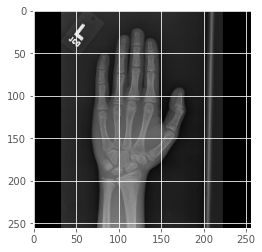

In [13]:
########################################
# Checking if the class dataset is working correctly
#######################################
ex_path = '/kaggle/input/i2a2-bone-age-regression/images/'
ex_path = [os.path.join(ex_path,i) for i in df_fold.fileName.values]
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)
ex_aug = A.Compose([
                     A.Resize(256,256),                
                     A.Normalize(mean,std,max_pixel_value = 255.0, always_apply = True)
                   ]
                   )
all_data = BoneAgeDataset_withGender(ex_path,
                        (df_fold.patientSex =='F').values*1,
                        df_fold.boneage.values,
                        augmentations = ex_aug).__getitem__(3)
img_ex = all_data['image']
gender_ex = all_data['gender']
imshow(img_ex)


## 5.3 Model

In [14]:
class Resnet152_withGender(nn.Module):
    '''
    Resnet152 & Adding the variable gender in the network
    '''
    def __init__(self, pretrained='imagenet'):
        super(Resnet152_withGender, self).__init__()
        
        self.base_model = pretrainedmodels.__dict__["resnet152"](pretrained=pretrained)
        self.l0 = nn.Linear(2048, 512)
        self.l1 = nn.Linear(1,32)
        self.last_layer = nn.Linear(512+32, 1)
        self.drop1 = nn.Dropout(p=0.2)
    
    def forward(self, image, gender):
        # Get dimensions of the image
        batch_size, _, _, _ = image.shape
        # Get the ouput of the Resnet model before the last linear layer
        x1 = self.base_model.features(image)
        # Adaptive Average pooling for flatenning 
        x1 = F.adaptive_avg_pool2d(x1, 1).reshape(batch_size, -1)
        # Adding a Linear Layer for the image arquitechture
        x1 = self.l0(x1)
        # Adding a Linear Layer for the gender arquitechture
        x2 = self.l1(gender.reshape(batch_size, -1))
        # Concatenate Image and Gender Layers
        x = torch.cat((x1, x2), dim=1)
        # Applying regularization (Dropout)
        x = self.drop1(x)
        # Aplying the last layer for regression
        out = self.last_layer(x)
        return out
    

## 5.4. Train, Validation, Predict Loop

In [15]:
def train_loop (data_loader,
               model,
               optimizer,
               device,
               scheduler=None,
               fp16 = False, # Mix precision of Apex
               accumulation_steps=1,
               loss_fn = None):
    if fp16: 
        accumulation_steps = 1
    # Initialize object Average Meter
    losses = AverageMeter()
    # List for store predicitons
    predictions = []
    # Put the model in train mode
    model.train() 
    if accumulation_steps>1:
        optimizer.zero_grad()
    # Defining the bar tqdm
    tk0 = tqdm(data_loader,total = len(data_loader))
    for b_idx,data in enumerate(tk0):
        # For items image/label
        for key,value in data.items(): 
             # We pass the same dtype as in the Melanoma Class
            data[key] = value.to(device)
        if accumulation_steps == 1 and b_idx == 0:
             # Put the gradients to 0
            optimizer.zero_grad()
        output_train = model(data['image'],data['gender'])
        loss = loss_fn(output_train,data['targets'].reshape(-1,1).type_as(output_train)) 
        
        with torch.set_grad_enabled(True):
            if fp16:
                with amp.scale_loss(loss,optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            if (b_idx + 1) % accumulation_steps ==0:
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
                if b_idx > 0:
                    optimizer.zero_grad()
        # Update loss in the progress bar
        losses.update(loss.item(), data_loader.batch_size)
        tk0.set_postfix(loss=losses.avg)
    # Return the average loss for the epoch
    return losses.avg 

def eval_loop(data_loader,
              model,
              device,
              loss_fn = None):
    # Initialize object Average Meter
    losses = AverageMeter()
    # Initialize list for store final predictions
    final_predictions = []
    # Put the model in eval mode
    model.eval()
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        for b_idx, data in enumerate(tk0):
            # For items image/label
            for key, value in data.items():
                data[key] = value.to(device)
            #Calculate the predictions
            predictions = model(data['image'],data['gender'])
            # Calculate the loss
            loss = loss_fn(predictions,data['targets'].reshape(-1,1).type_as(predictions)) 
            # Pass predictions to CPU mode
            predictions = predictions.cpu()
            # Update loss
            losses.update(loss.item(), data_loader.batch_size)
            # Append predictions
            final_predictions.append(predictions)
            tk0.set_postfix(loss=losses.avg)
    #Return final predictions & average loss
    return final_predictions, losses.avg 


def predict(data_loader, model, device):
    # Put the model in eval mode
    model.eval()
    # List for store final predictions
    final_predictions = []
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
            predictions = model(data['image'],data['gender'])
            predictions = predictions.cpu()
            final_predictions.append(predictions)
    return final_predictions


## 5.5 Running Training Function

+ In this function we run the model training
+ Data augmentation for training is:
    + Resize: From (1024,2014) -> (512,512). I choose this larger resolution because it gave me better results than     (480,480), (256,256) , (244,244)
    + ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15)
    + RandomBrightness(limit = 0.2),
    + Horizontal & Vercial Flip
    + Normalization
                        
+ Data augmentation for validation is:
    + Resize (512,512)
    + Horizontal & Vertical Flip (In order to make our model indiferent to position of the hand )
    + Normalization

+ Model:
    + Arquitechture: Resnet 152 with tabular variable (Gender)
    + Optimizer: Adam

In [16]:
def run_with_gender(fold, prev_model_path = None):
    '''
    Function to train and evaluate the model
    Input:
    - fold            : Fold used for evaluation, other folds are used for training
    - prev_model_path : Path for a model for continue the training process
    '''
    # General Parameters
    # 1. image_path        : Path that have images for training and evaluation
    # 2. df_fold           : Dataframe that has the column folds
    # 3. device            : Device used for training
    # 4. epochs            : Number of epochs for training
    # 5. train_bs          : Training Batch size
    # 6. valid_bs          : Validation Batch size
    # 7. loss_fn           : Loss function 
    # 8. model_path        : Path for saving the model
    # 9. all_path          : Path for saving the model, optimizer, and other indicators
    # 10.df_train          : Dataframe that constains the images for training
    # 11.df_valid          : Dataframe that constains the images for validation
    
    image_path = '/kaggle/input/i2a2-bone-age-regression/images/'
    model_path = './Bone_age_Regression_Resnet_152_with_gender.pt'
    all_path = './Files_bone_age_regression_resnet_152_with_gender.pt'
    device = 'cuda'
    epochs = 35
    train_bs = 16
    valid_bs = 16
    loss_fn = nn.MSELoss()
    df_fold = pd.read_csv('folds.csv').rename(columns = {'boneage':'target'})
    df_train = df_fold[df_fold.fold != fold].reset_index(drop = True)
    df_valid = df_fold[df_fold.fold == fold].reset_index(drop = True)
    
    # Mean & Standard deviations of Imagenet
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)
    
    # Training data augmentations:
    train_aug = A.Compose(
                    [
                        A.Resize(512,512),
                        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
                        A.RandomBrightness(limit = 0.2),
                        A.HorizontalFlip(),
                        A.VerticalFlip(),
                        A.Normalize(mean,std,max_pixel_value = 255.0, always_apply = True)
        
                    ]
                                       )
    
    # Special Validation: I want a model that learn with flips
    valid_aug = A.Compose(
                    [
                        A.Resize(512,512),
                        A.HorizontalFlip(),
                        A.VerticalFlip(),
                        A.Normalize(mean,std,max_pixel_value = 255.0, always_apply = True)
                        
                    ]
                         )
    
    # For Training (Images, Gender, Target)
    train_images  = [os.path.join(image_path,i) for i in df_train.fileName.values]
    train_genders = (df_train.patientSex =='F').values*1
    train_targets = df_train.target.values
    
    
    # For Validation
    valid_images  = [os.path.join(image_path,i) for i in df_valid.fileName.values]
    valid_genders = (df_valid.patientSex =='F').values*1
    valid_targets = df_valid.target.values
    

    # Creating the Datasets and dataloaders
    train_dataset = BoneAgeDataset_withGender(train_images,train_genders,train_targets, augmentations = train_aug)
    valid_dataset = BoneAgeDataset_withGender(valid_images,valid_genders,valid_targets, augmentations = valid_aug)
    
    train_dataloader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size = train_bs,
                        shuffle = True,
                        num_workers = 4
                        )
    
    valid_dataloader = torch.utils.data.DataLoader(
                        valid_dataset,
                        batch_size = valid_bs,
                        shuffle = False, 
                        num_workers = 4
                        )
    
    # Flag for indetify if we will continue training
    if prev_model_path!= None:
        print('Loading Previous modeling...')
        checkpoint = torch.load(prev_model_path)
        # Loading Model
        # 1. Model
        model = Resnet152_withGender()
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        # 2.Optmizer
        optimizer = torch.optim.Adam(model.parameters())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # 3. Epoch
        epoch_score = checkpoint['epoch_score']
        epoch_last = checkpoint['epoch']
        # 4. Early Stopping
        es = EarlyStopping (patience = 5, mode = 'min',last_val_score = epoch_score)
        print('Last number epoch: ',epoch_last)
        
    else:    
        print("****** Init Training ******")        
        str_='Init Training'
        os.system('echo '+str_)
        model = Resnet152_withGender()
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer,
                    patience = 3,
                    mode = "min" 
                    )

        es = EarlyStopping (patience = 5, mode = 'min')
        
    losses_train = []
    losses_val   = []
    rmse_val_list   = []
    for epoch in range(epochs):
        # Training Loop
        training_loss = train_loop(train_dataloader,
                                   model,
                                   optimizer,
                                   device,
                                   scheduler=None, # We are using LRonPlateu
                                   fp16 = False,
                                   accumulation_steps=1,
                                   loss_fn = loss_fn)
        
        # Validation Loop
        predictions, valid_loss = eval_loop(valid_dataloader,
                                            model, 
                                            device,
                                            loss_fn= loss_fn)
        
        predictions = np.vstack((predictions)).ravel() 
        rmse_score  = np.sqrt(mean_squared_error(valid_targets,predictions))
        mae_score   = mean_absolute_error(valid_targets,predictions)
        str_=f'epoch={epoch},rmse={rmse_score}, mse_score = {mae_score}'
        os.system('echo '+str_)
        # Optimizer Step:
        scheduler.step(rmse_score)
        print('Epoch {}, lr {}'.format(epoch, optimizer.param_groups[0]['lr']))
        print(f'epoch={epoch},rmse={rmse_score}, mse_score = {mae_score}')
        es(epoch,rmse_score,model,optimizer, model_path,all_path)
        # Saving losses:
        losses_train.append(training_loss)
        losses_val.append(valid_loss)
        rmse_val_list.append(rmse_score)
        if es.early_stop:
            print('early stopping')
            break
        gc.collect()
    return losses_train,losses_val,rmse_val_list

In [17]:
losses_train,losses_val,rmse_val_list = run_with_gender(fold=0)

****** Init Training ******


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


100%|██████████| 158/158 [01:07<00:00,  2.33it/s, loss=456]


Epoch 0, lr 0.0001
epoch=0,rmse=21.353608012947088, mse_score = 17.554597305769587
Validation score improved (inf --> 21.353608012947088). Saving model!


100%|██████████| 158/158 [01:07<00:00,  2.34it/s, loss=329]


Epoch 1, lr 0.0001
epoch=1,rmse=18.142789801920312, mse_score = 14.778500356231943
Validation score improved (21.353608012947088 --> 18.142789801920312). Saving model!


100%|██████████| 158/158 [01:07<00:00,  2.36it/s, loss=203]


Epoch 2, lr 0.0001
epoch=2,rmse=14.233134453623546, mse_score = 11.167568894354918
Validation score improved (18.142789801920312 --> 14.233134453623546). Saving model!


100%|██████████| 158/158 [01:07<00:00,  2.35it/s, loss=165]


Epoch 3, lr 0.0001
epoch=3,rmse=12.830650476872382, mse_score = 9.930892023546942
Validation score improved (14.233134453623546 --> 12.830650476872382). Saving model!


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 4, lr 0.0001
epoch=4,rmse=14.525203643930304, mse_score = 11.53089025518604
EarlyStopping counter: 1 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 5, lr 0.0001
epoch=5,rmse=13.546456229260954, mse_score = 10.477049011112536
EarlyStopping counter: 2 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 6, lr 0.0001
epoch=6,rmse=15.420434693960235, mse_score = 11.591431172839998
EarlyStopping counter: 3 out of 5


100%|██████████| 158/158 [01:07<00:00,  2.33it/s, loss=140]


Epoch 7, lr 0.0001
epoch=7,rmse=11.81461797503159, mse_score = 9.224049876050914
Validation score improved (12.830650476872382 --> 11.81461797503159). Saving model!


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 8, lr 0.0001
epoch=8,rmse=11.955163361538544, mse_score = 9.345929191172052
EarlyStopping counter: 1 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 9, lr 0.0001
epoch=9,rmse=12.444942780486045, mse_score = 9.958790124431282
EarlyStopping counter: 2 out of 5


100%|██████████| 158/158 [01:07<00:00,  2.34it/s, loss=131]


Epoch 10, lr 0.0001
epoch=10,rmse=11.448143140252018, mse_score = 8.925005746086203
Validation score improved (11.81461797503159 --> 11.448143140252018). Saving model!


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 11, lr 0.0001
epoch=11,rmse=11.702117849809348, mse_score = 9.154686622755706
EarlyStopping counter: 1 out of 5


100%|██████████| 158/158 [01:07<00:00,  2.33it/s, loss=131]


Epoch 12, lr 0.0001
epoch=12,rmse=11.427257035877611, mse_score = 8.87355371217051
Validation score improved (11.448143140252018 --> 11.427257035877611). Saving model!


100%|██████████| 158/158 [01:07<00:00,  2.35it/s, loss=126]


Epoch 13, lr 0.0001
epoch=13,rmse=11.240590762541473, mse_score = 8.671663085477862
Validation score improved (11.427257035877611 --> 11.240590762541473). Saving model!


100%|██████████| 158/158 [01:07<00:00,  2.33it/s, loss=118]


Epoch 14, lr 0.0001
epoch=14,rmse=10.875405357298893, mse_score = 8.283389900395004
Validation score improved (11.240590762541473 --> 10.875405357298893). Saving model!


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 15, lr 0.0001
epoch=15,rmse=10.983350095209829, mse_score = 8.498297928724316
EarlyStopping counter: 1 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 16, lr 0.0001
epoch=16,rmse=11.282772081318287, mse_score = 8.868143335108808
EarlyStopping counter: 2 out of 5


100%|██████████| 158/158 [01:07<00:00,  2.34it/s, loss=101]


Epoch 17, lr 0.0001
epoch=17,rmse=10.050224371511407, mse_score = 7.644151313055426
Validation score improved (10.875405357298893 --> 10.050224371511407). Saving model!


100%|██████████| 158/158 [01:08<00:00,  2.32it/s, loss=98.2]


Epoch 18, lr 0.0001
epoch=18,rmse=9.911084897336425, mse_score = 7.489001421076979
Validation score improved (10.050224371511407 --> 9.911084897336425). Saving model!


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 19, lr 0.0001
epoch=19,rmse=10.331191664130765, mse_score = 7.916277144005314
EarlyStopping counter: 1 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 20, lr 0.0001
epoch=20,rmse=10.128723815769069, mse_score = 7.7280086277497935
EarlyStopping counter: 2 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 21, lr 0.0001
epoch=21,rmse=10.027056853662351, mse_score = 7.618965127332977
EarlyStopping counter: 3 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 24, lr 0.0001
epoch=24,rmse=10.169540852752238, mse_score = 7.7185328399856274
EarlyStopping counter: 2 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 25, lr 0.0001
epoch=25,rmse=10.316082305792895, mse_score = 8.081530626820422
EarlyStopping counter: 3 out of 5


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch 29, lr 1e-05
epoch=29,rmse=9.541215004651148, mse_score = 7.362245655466156
EarlyStopping counter: 1 out of 5


100%|██████████| 158/158 [01:07<00:00,  2.35it/s, loss=86.2]


Epoch 30, lr 1e-05
epoch=30,rmse=9.28872610165479, mse_score = 7.0149607742017
Validation score improved (9.530476023490305 --> 9.28872610165479). Saving model!


100%|██████████| 158/158 [01:08<00:00,  2.32it/s, loss=85.6]


Epoch 34, lr 1e-05
epoch=34,rmse=9.25392330202864, mse_score = 7.042522957057552
Validation score improved (9.28872610165479 --> 9.25392330202864). Saving model!


## Plotting Losses & Rmse

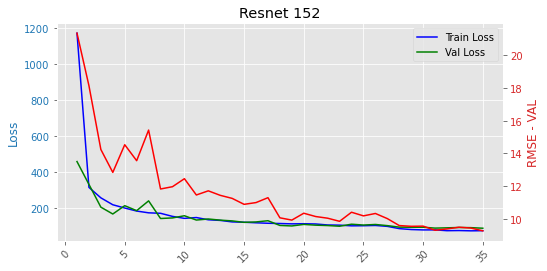

In [18]:
indexes = [i for i in range(1,len(losses_train)+1)]
fig, ax = plt.subplots(1, 1, figsize=(8,4))
# 1.3 Plot Frequency with bad rate line and reference
# 1.3.1 Barplot 
color = 'tab:blue'
ax.set_title('Resnet 152')
ax.yaxis.set_label_position("left")
ax.set_ylabel('Loss', color=color) 
ax.yaxis.tick_left()
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', labelcolor=color)
ax.plot(indexes,losses_train, color = 'b', linestyle = "solid", label = 'Train Loss')
ax.plot(indexes,losses_val, color = 'g', linestyle = "solid",label = 'Val Loss')
# Plot Line

# Put the percentage on the bars

# 1.3.2 Adding bad rate line and reference  
ax2 = fig.add_subplot(1, 1, 1, sharex = ax, frameon = False)
color = 'tab:red'
ax2.plot(indexes,rmse_val_list, color = 'r', linestyle = "solid",label = 'RMSE-VAL')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('RMSE - VAL', color=color) 
ax2.yaxis.tick_right()
ax2.tick_params(axis='y', labelcolor=color)
ax.legend()
ax2.axes.get_xaxis().set_visible(False)
ax2.grid(False)

# 6. Predict 

+ In this step we load the images that has been preprocessing for the test from a brazilian hospital

## 6.1 Check preprocessed test dataset

In [19]:
images_test = glob.glob(os.path.join('../input/bone-age-regression-test-dataset/test_images_padding','*.png'))

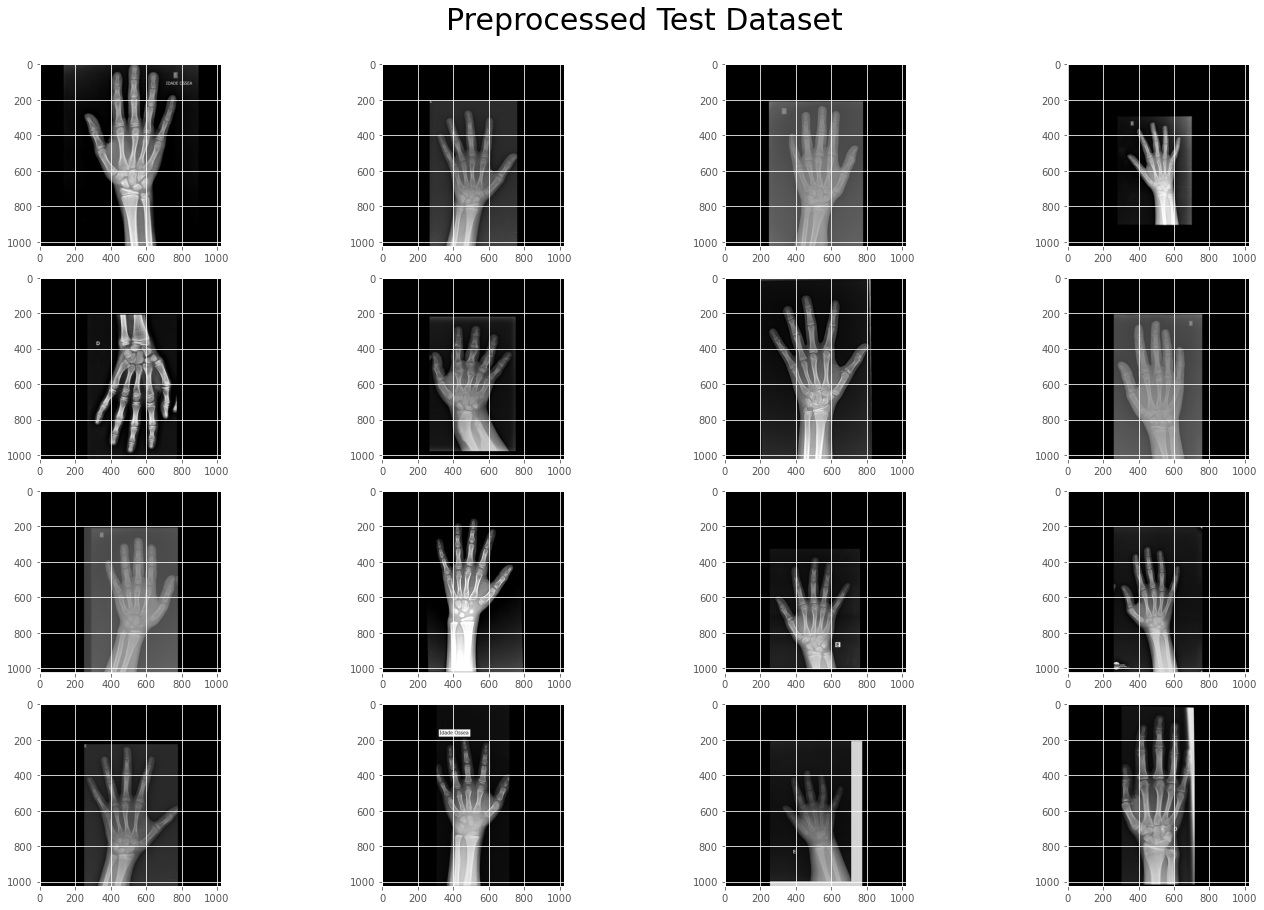

In [20]:
# Visualizing preprocessed test images
row = 4; col = 4;
plt.figure(figsize=(20,(row/col)*12))
plt.suptitle("Preprocessed Test Dataset",  y=1.05, fontsize=30)
for j in range(row*col):
    plt.subplot(row,col,j+1)
    plt.imshow(cv2.imread(images_test[j]))
plt.tight_layout()
plt.show()

## 6.2 Make Prediction file

In [21]:
# Create a Dataframe for evaluating images from preprocesed test
df_preproc_test = pd.DataFrame()
df_preproc_test['ListName'] = images_test
df_preproc_test['fileName'] = images_test
df_preproc_test['fileName'] = df_preproc_test.apply(lambda x: apply_filename_name(x),axis = 1)
df_preproc_test = df_preproc_test.merge(pd.read_csv(os.path.join(path,'sample_submission.csv')),on='fileName')

# Loading Model 
checkpoint = torch.load('./Files_bone_age_regression_resnet_152_with_gender.pt')
model_resnet = Resnet152_withGender()
model_resnet.load_state_dict(checkpoint['model_state_dict'])
model_resnet.to('cuda')

# Parameters needed for test
list_test = df_preproc_test['ListName'].values
test_targets = [-1]*len(list_test)
test_gender = (df_preproc_test.patientSex =='F').values*1

mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

# Augmentation for test
test_aug = A.Compose(
                    [
                        A.Resize(512,512),
                        A.Normalize(mean,std,max_pixel_value = 255.0, always_apply = True)
                        
                    ]
                                       )
# Creating the Datasets and dataloaders for test

test_dataset = BoneAgeDataset_withGender(list_test, test_gender, test_targets, augmentations = test_aug)
test_dataloader = torch.utils.data.DataLoader(
                    test_dataset,
                    batch_size = 16,
                    shuffle = False, # Keep it False with wtfml and evaluate the metric
                    num_workers = 4
                    )

test_pred = predict(test_dataloader, model_resnet, 'cuda')

# Create submission for Kaggle competition

df_sub = pd.DataFrame()
df_sub['ImageFile'] = list_test
df_sub['boneage'] = np.vstack((test_pred)).ravel()
df_sub['Image_Side'] = df_sub.apply(lambda x: apply_filename_side(x),axis = 1)
df_sub['fileName'] = df_sub.apply(lambda x: apply_filename_name2(x),axis = 1)

# Get the mean of predicition of each image
df_sub   = df_sub.groupby(['fileName'])['boneage'].mean()
df_final = pd.read_csv(os.path.join(path,'sample_submission.csv'))
df_final.drop(columns = 'boneage',inplace = True)
df_final = df_final.merge(df_sub,on='fileName')[['fileName','boneage','patientSex']]
df_final2 = df_final.copy()
df_final = df_final.drop(columns='patientSex') 
df_final.to_csv('Submission_ResNet_152.csv',index=False)


100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


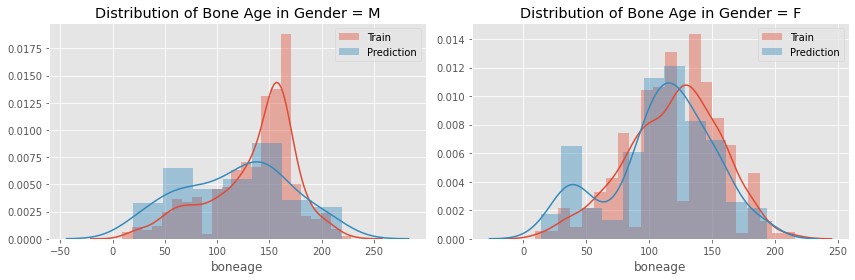

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(df_ttrain[df_ttrain['patientSex']=='M']['boneage'], label = 'Train')
sns.distplot(df_final2[df_final2['patientSex']=='M']['boneage'],label = 'Prediction')
plt.legend()
plt.title('Distribution of Bone Age in Gender = M')
plt.subplot(1,2,2)
sns.distplot(df_ttrain[df_ttrain['patientSex']=='F']['boneage'], label = 'Train')
sns.distplot(df_final2[df_final2['patientSex']=='F']['boneage'],label = 'Prediction')
plt.legend()
plt.title('Distribution of Bone Age in Gender = F')
plt.tight_layout()
plt.show()